In [35]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import keras
from keras import layers
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import tqdm
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


In [2]:
# hyper-parameters
ROOT_FOLDER = "..\.."
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
TRAIN_FOLDER = os.path.join(DATA_FOLDER, "train_set")
TEST_FOLDER = os.path.join(DATA_FOLDER, "test_set")
PROCESSED_DATA = os.path.join(ROOT_FOLDER, 'processed_data')
TEMPLATE_FOLDER = os.path.join(PROCESSED_DATA, 'templates')

In [3]:
def create_dataset(processed_data=True, train=True, anomaly=False):
    """
    gather all files from all folders in the train or test folder

    :type: str representing which files we want
    :return: list containing
    """

    # define whether to use train or test set
    if train:
        data_set = 'train_set'
    else:
        data_set = 'test_set'

    # define whether to use processed or original data
    if processed_data:
        data_folder = PROCESSED_DATA
        templates = [1,2,3,4,5,6]
    else:
        data_folder = DATA_FOLDER
        template_folder = os.path.join(DATA_FOLDER, data_set)
        templates = os.listdir(template_folder)

    # choose anomalous dice if set as parameter
    if anomaly:
        templates = ["ano"]

    # initialize return types
    data = []
    label = []

    for template in templates:
        # get the folder name, all filenames inside it, and make a list of all the image files inside
        train_folder = os.path.join(data_folder, data_set)
        folder = os.path.join(train_folder, str(template))
        filenames = os.listdir(folder)
        files = [file for file in filenames if ".png" in file]

        for file in files:
            img = Image.open(os.path.join(folder,file))
            data.append(np.array(img))
            label.append(template)
            
    label= np.array(label).reshape(-1,1)

    return data, label


In [4]:
def SSIMLoss(y_true, y_pred):
  y_true = tf.cast(y_true,tf.float32)
  y_pred = tf.cast(y_pred,tf.float32)
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [5]:
def BinaryCrossEntropy(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
    term_0 = (1-y_true) * np.log(1-y_pred + 1e-7)
    term_1 = y_true * np.log(y_pred + 1e-7)
    return tf.reduce_mean(-np.mean(term_0+term_1, axis=0))

In [6]:
def split_and_preprocess_dataset(data, split = True):
    data = np.array(data)
    preprocessed_data = data/255
    preprocessed_data = np.expand_dims(preprocessed_data, axis=3)

    if not split:
        return preprocessed_data, _, _, _, _, _, _, _

    # split data in train/val/test set
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        preprocessed_data, 
        labels,
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, 
        train_val_labels,
        test_size=0.3, 
        random_state=42, 
        shuffle=True
    )

    return train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels

In [7]:
# gather, process and preprocess all training data.

data, labels = create_dataset(processed_data=True, train=True)
train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels = split_and_preprocess_dataset(data)

In [46]:
# gather, process and preprocess all training data.

anomalies, _ = create_dataset(processed_data=True, train=True, anomaly=True)
anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(anomalies, split = False)
np.random.shuffle(anomalies)

normies, _ = create_dataset(processed_data=True, train=True, anomaly=False)
normies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(normies, split = False)
np.random.shuffle(normies)


In [9]:
# gather the unseen testing data set

test_normals, _ = create_dataset(processed_data=True, train=False, anomaly=False)
test_normals, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_normals, split = False)

test_anomalies, _ = create_dataset(processed_data=True, train=False, anomaly=True)
test_anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(test_anomalies, split = False)

In [10]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [11]:
# hyper_params

original_dim = 128 * 128
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)

In [12]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [13]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [14]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [15]:
train_data = train_data.reshape((len(train_data), np.prod(train_data.shape[1:])))
val_data = val_data.reshape((len(val_data), np.prod(val_data.shape[1:])))

In [43]:
np.random.shuffle(train_data)
np.random.shuffle(val_data)

In [18]:
vae.fit(train_data, train_data,
        epochs=100,
        batch_size=32,
        validation_data=(val_data, val_data))

Epoch 1/100
115/115 [==============================] - 8s 66ms/step - loss: 32720.4648 - val_loss: 7132.6055
Epoch 2/100
115/115 [==============================] - 9s 76ms/step - loss: 6667.9082 - val_loss: 6413.5029
Epoch 3/100
115/115 [==============================] - 8s 67ms/step - loss: 6305.7949 - val_loss: 6230.8662
Epoch 4/100
115/115 [==============================] - 8s 66ms/step - loss: 6182.0825 - val_loss: 6146.9668
Epoch 5/100
115/115 [==============================] - 8s 67ms/step - loss: 6118.3301 - val_loss: 6098.8267
Epoch 6/100
115/115 [==============================] - 8s 67ms/step - loss: 6078.9243 - val_loss: 6066.6587
Epoch 7/100
115/115 [==============================] - 8s 67ms/step - loss: 6052.1626 - val_loss: 6043.8867
Epoch 8/100
115/115 [==============================] - 8s 67ms/step - loss: 6032.3257 - val_loss: 6026.3145
Epoch 9/100
115/115 [==============================] - 8s 67ms/step - loss: 6016.6074 - val_loss: 6013.0317
Epoch 10/100
115/115 [=====

In [19]:
autoencoder = vae

In [20]:
autoencoder.save_weights('../../models/v2_3w.h5')

In [19]:
autoencoder = vae

In [27]:
normies.shape[0]

6571

In [28]:
autoencoder.predict(normies.reshape(normies.shape[0], 16384))

array([[0.99985886, 0.99999714, 1.        , ..., 1.        , 1.        ,
        0.9999971 ],
       [0.99988383, 0.9999971 , 1.        , ..., 1.        , 1.        ,
        0.99999684],
       [0.99985313, 0.9999976 , 1.        , ..., 1.        , 1.        ,
        0.9999975 ],
       ...,
       [0.9999541 , 0.9999995 , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.9999522 , 0.9999994 , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [0.99994373, 0.99999934, 1.        , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

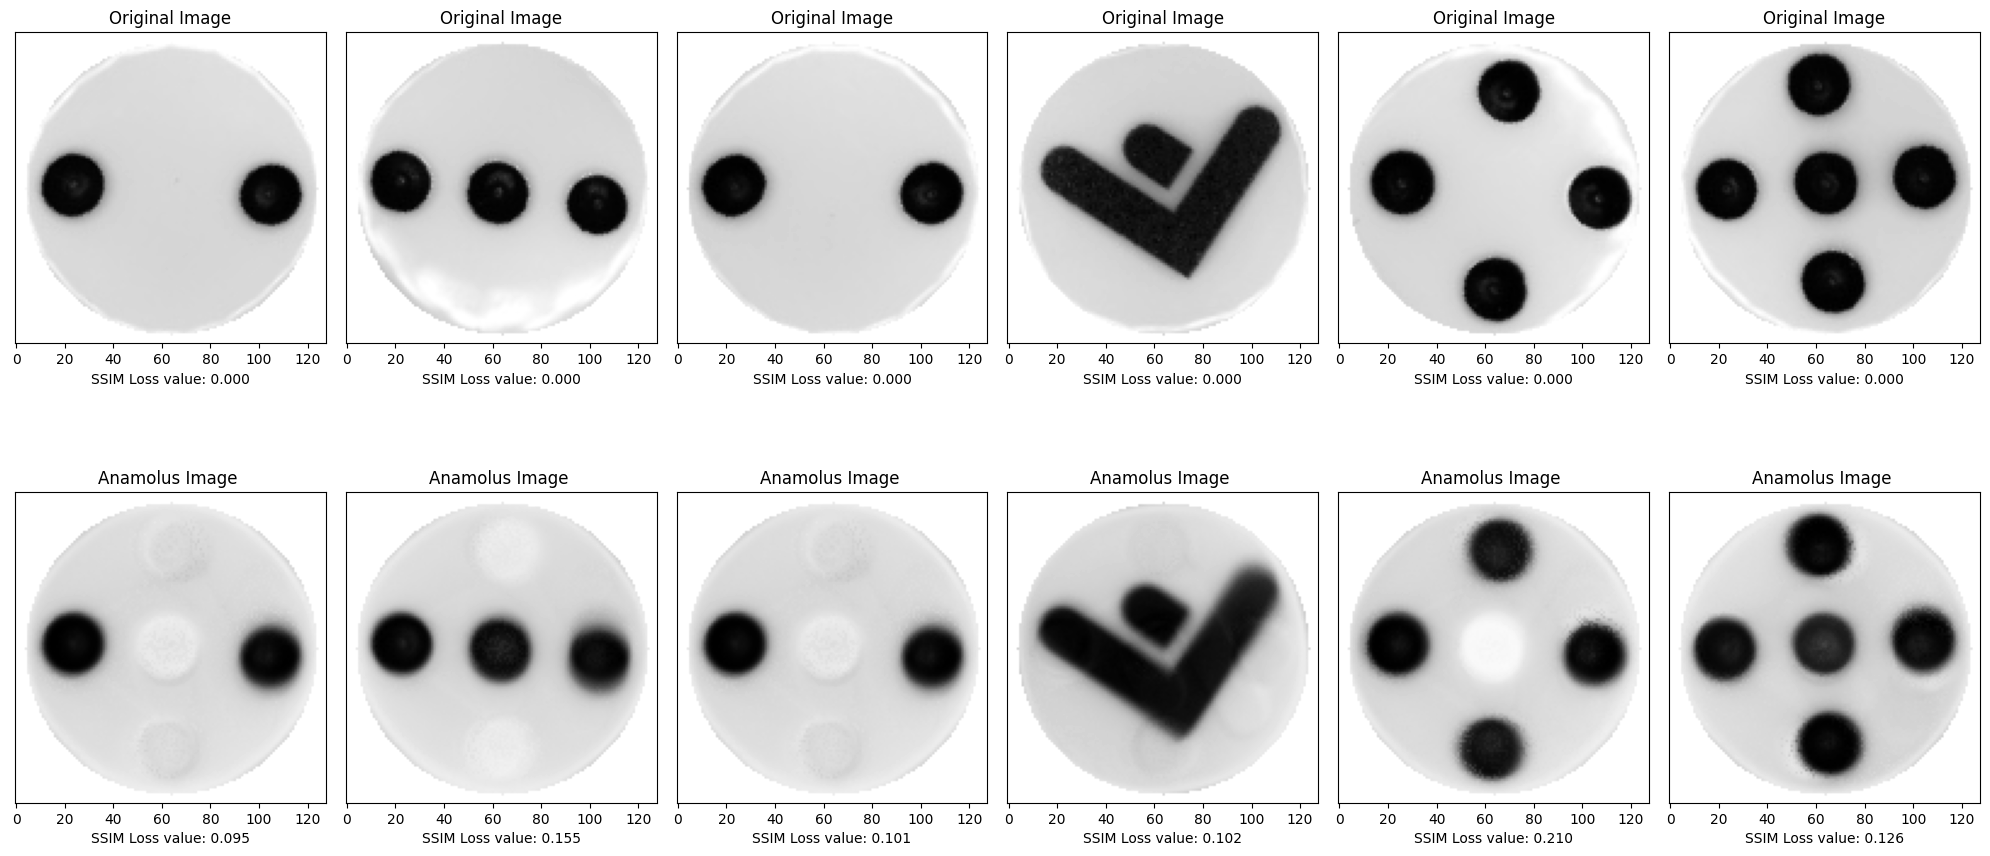

In [49]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):
    result = autoencoder.predict(normies[i].reshape(1,16384))
    decoded_imgs.append(result.reshape(128,128,1))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(normies[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(normies[i], normies[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_imgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, normies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

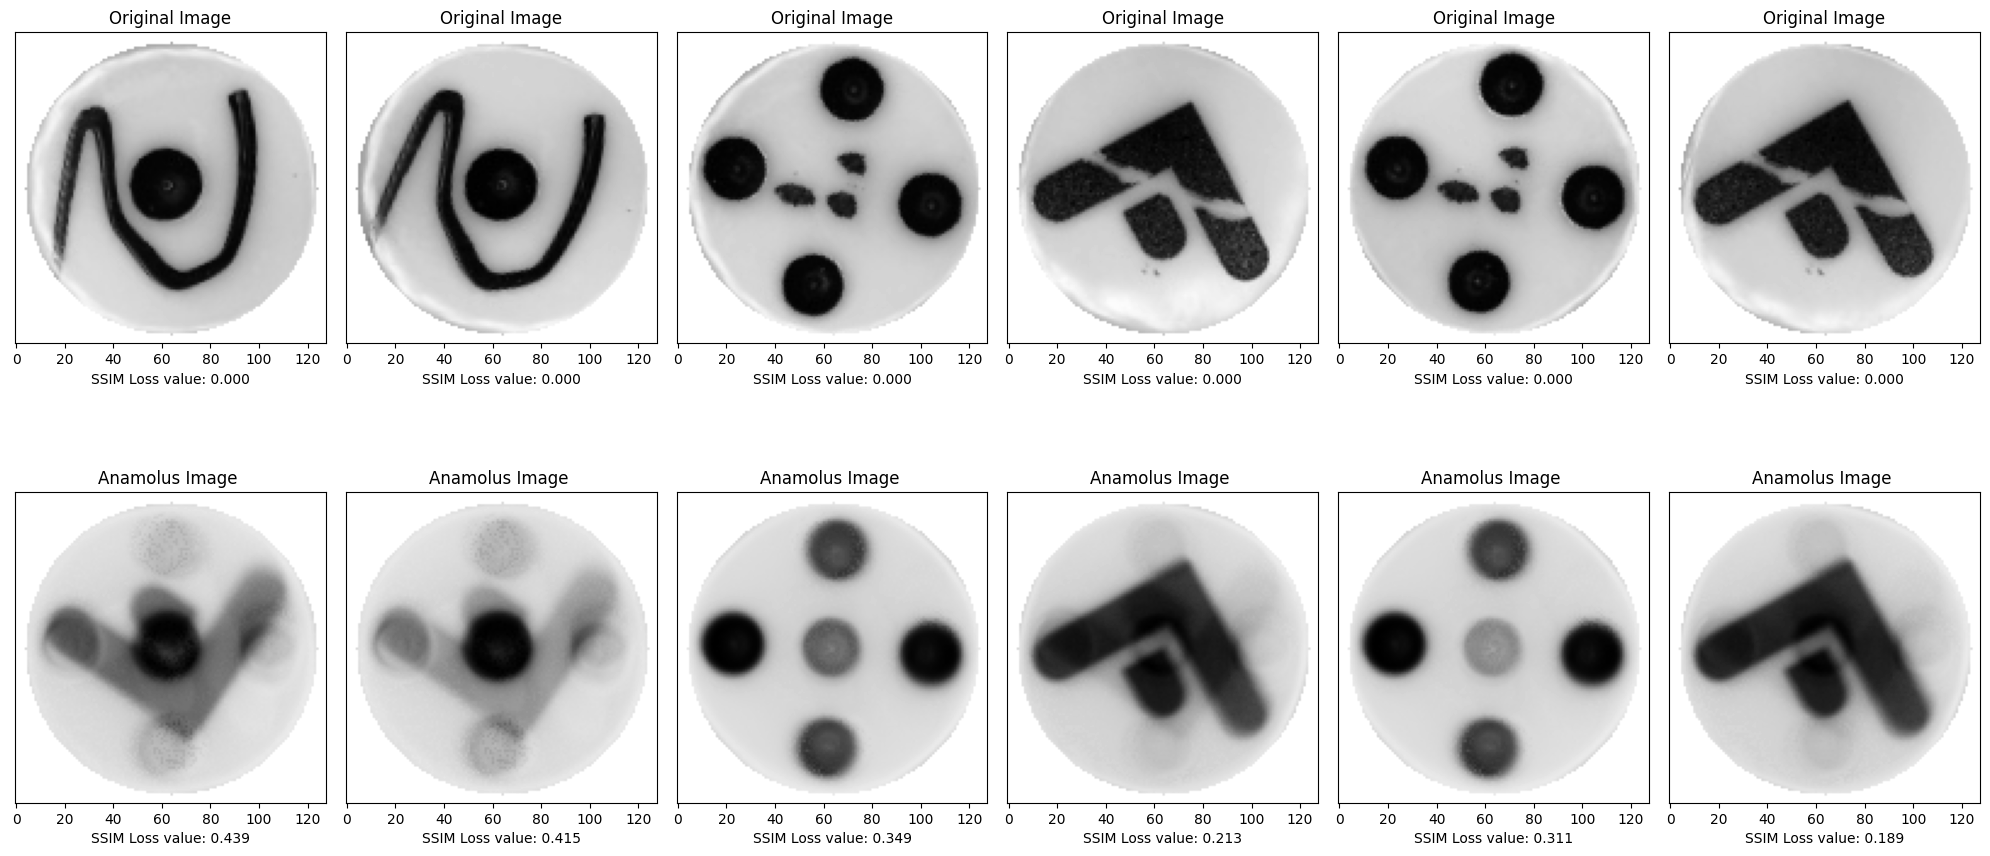

In [48]:
%matplotlib inline
n = 6  # how many encoded and decoded images we will display

plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1

decoded_imgs = []
decoded_mnistimgs = []

for i in range(n):
    result = autoencoder.predict(anomalies[i].reshape(1,16384))
    decoded_imgs.append(result.reshape(128,128,1))

for i in range(n):

    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(anomalies[i].reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(anomalies[i], anomalies[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n)
    img_2 = decoded_imgs[i].reshape(128,128,1)
    plt.imshow(img_2.reshape(128,128), cmap="gray")
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(img_2, anomalies[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
    
plt.tight_layout()
plt.show()

In [57]:
# evaluate

In [68]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_stats(predictions, labels, print = True):
    if print:
        print("f1 = {}".format(f1_score(labels, predictions)))
        print("Accuracy = {}".format(accuracy_score(labels, predictions)))
        print("Precision = {}".format(precision_score(labels, predictions)))
        print("Recall = {}".format(recall_score(labels, predictions)))
    return f1_score(labels, predictions), accuracy_score(labels, predictions), precision_score(labels, predictions), recall_score(labels, predictions)

def predictor(ano_pred, norm_pred, threshold):
    threshold = np.float32(threshold)
    predictions = []
    labels = []

    for pred in ano_pred:
        labels.append(1)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    for pred in norm_pred:
        labels.append(0)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)


    return predictions, labels


In [55]:
def calculate_threshold(samples):
    """
    
    :samples: n samples, or over how many samples we want to calculate the threshold.
    """

    ano_predictions = []
    norm_predictions = []

    for ano in tqdm.tqdm(anomalies[:samples]):

        result = autoencoder.predict(ano.reshape(1,16384))
        result = result.reshape(128,128,1)

        ano_predictions.append(SSIMLoss(ano, result).numpy())

    for sample in tqdm.tqdm(normies[:samples]):

        result = autoencoder.predict(sample.reshape(1,16384))
        result = result.reshape(128,128,1)

        norm_predictions.append(SSIMLoss(sample, result).numpy())

    threshold = np.mean([np.mean(norm_predictions), np.mean(ano_predictions)])
    return threshold

In [56]:
threshold = calculate_threshold(100)

100%|██████████| 100/100 [00:12<00:00,  7.90it/s]


In [61]:
# predicting for the anomalies in the testing set

ano_predictions_t = []
norm_predictions_t = []

for ano in test_anomalies:

    result = autoencoder.predict(ano.reshape(1,16384))
    result = result.reshape(128,128,1)

    ano_predictions_t.append(SSIMLoss(ano, result))

for sample in tqdm.tqdm(test_normals):

    result = autoencoder.predict(sample.reshape(1,16384))
    result = result.reshape(128,128,1)

    norm_predictions_t.append(SSIMLoss(sample, result).numpy())

predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold)
print_stats(predictions, labels)

100%|██████████| 330/330 [00:46<00:00,  7.13it/s]

f1 = 0.4423076923076923
Accuracy = 0.8370786516853933
Precision = 0.2948717948717949
Recall = 0.8846153846153846


In [75]:
coeff = 0.1

predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold + coeff)
results = print_stats(predictions, labels, print = False)
results

(0.7555555555555555,
 0.9691011235955056,
 0.8947368421052632,
 0.6538461538461539)

In [72]:
coeff = 0.01

for x in range(30):
    coeff += 0.01 

    predictions, labels = predictor(ano_predictions_t, norm_predictions_t, threshold + coeff)
    results = print_stats(predictions, labels, print = False)
    print(coeff, " gives ", results[0])

0.02  gives  0.5641025641025641
0.03  gives  0.6000000000000001
0.04  gives  0.6153846153846154
0.05  gives  0.6785714285714285
0.060000000000000005  gives  0.6909090909090909
0.07  gives  0.68
0.08  gives  0.7391304347826088
0.09  gives  0.7555555555555555
0.09999999999999999  gives  0.7555555555555555
0.10999999999999999  gives  0.7317073170731707
0.11999999999999998  gives  0.6666666666666666
0.12999999999999998  gives  0.631578947368421
0.13999999999999999  gives  0.631578947368421
0.15  gives  0.5945945945945945
0.16  gives  0.5142857142857142
0.17  gives  0.47058823529411764
0.18000000000000002  gives  0.47058823529411764
0.19000000000000003  gives  0.47058823529411764
0.20000000000000004  gives  0.47058823529411764
0.21000000000000005  gives  0.47058823529411764
0.22000000000000006  gives  0.42424242424242425
0.23000000000000007  gives  0.42424242424242425
0.24000000000000007  gives  0.2666666666666667
0.25000000000000006  gives  0.2666666666666667
0.26000000000000006  gives  0.

In [78]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==0:
           TP += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==1:
           TN += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [79]:
perf_measure(labels, predictions)

(328, 9, 17, 2)